In sequential methods the different combined weak models are no longer fitted independently from each others. The idea is to fit models iteratively such that the training of model at a given step depends on the models fitted at the previous steps. “Boosting” is the most famous of these approaches and it produces an ensemble model that is in general less biased than the weak learners that compose it.

### Boosting:

Boosting methods work in the same spirit as bagging methods: we build a family of models that are aggregated to obtain a strong learner that performs better. However, unlike bagging that mainly aims at reducing variance, boosting is a technique that consists in fitting sequentially multiple weak learners in a very adaptative way: each model in the sequence is fitted giving more importance to observations in the dataset that were badly handled by the previous models in the sequence. Intuitively, each new model focus its efforts on the most difficult observations to fit up to now, so that we obtain, at the end of the process, a strong learner with lower bias (even if we can notice that boosting can also have the effect of reducing variance). Boosting, like bagging, can be used for regression as well as for classification problems.

Being mainly focused at reducing bias, the base models that are often considered for boosting are models with low variance but high bias. For example, if we want to use trees as our base models, we will choose most of the time shallow decision trees with only a few depths. Another important reason that motivates the use of low variance but high bias models as weak learners for boosting is that these models are in general less computationally expensive to fit (few degrees of freedom when parametrised). Indeed, as computations to fit the different models can’t be done in parallel (unlike bagging), it could become too expensive to fit sequentially several complex models.

Once the weak learners have been chosen, we still need to define how they will be sequentially fitted (what information from previous models do we take into account when fitting current model?) and how they will be aggregated (how do we aggregate the current model to the previous ones?). We will discuss these questions in the two following subsections, describing more especially two important boosting algorithms: adaboost and gradient boosting.

**In a nutshell, these two meta-algorithms differ on how they create and aggregate the weak learners during the sequential process. Adaptive boosting updates the weights attached to each of the training dataset observations whereas gradient boosting updates the value of these observations. This main difference comes from the way both methods try to solve the optimisation problem of finding the best model that can be written as a weighted sum of weak learners.**

### Adaboost:

The name AdaBoost stands for Adaptive Boosting, and it refers to a particular boosting algorithm in which we fit a sequence of “stumps” (decision trees with a single node and two leaves) and weight their contribution to the final vote by how accurate their predictions are. After each iteration, we re-weight the dataset to assign greater importance to data points which were misclassified by the previous weak learner, so that those data points get “special attention” during iteration `t+1`.

The following figure illustrates how weights impact the performance of a simple decision stump(tree with depth 1)

<p>
    <img src = "assets/17.png/" width = "600px" height = "600px">
    
</p>

#### Pseudocode

There are several different algorithms proposed by researchers. Here I’ll introduce the most popular method called **SAMME, a specific method that deals with multi-classification problems. [(Zhu, H. Zou, S. Rosset, T. Hastie, “Multi-class AdaBoost”, 2009)](https://web.stanford.edu/~hastie/Papers/samme.pdf)**

<p>
    <img src = "assets/18.png/" width = "600px" height = "600px">
    
</p>

AdaBoost trains a sequence of models with augmented sample weights, generating ‘confidence’ coefficients Alpha for individual classifiers based on errors. Low errors leads to large Alpha, which means higher importance in the voting.

<p>
    <img src = "assets/19.png/" width = "600px" height = "600px">
    
</p>

<p>
    <img src = "assets/20.png/" width = "600px" height = "600px">
    
</p>
<p>
    <img src = "assets/21.png/" width = "600px" height = "600px">
    
</p>
<p>
    <img src = "assets/22.png/" width = "600px" height = "600px">
    
</p>
<p>
    <img src = "assets/23.png/" width = "600px" height = "600px">
    
</p>

#### AdaBoost.M1 and SAMME are simple generalizations of AdaBoost for more than two classes. In AdaBoost-SAMME the individual trees are required to have an error lower than 1-1/n classes instead of 1/2 of the AdaBoost.M1

### Code from scratch 1: Adaboost M1



In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
sns.set_style('white')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [6]:
# Dataset and utitlity plotting function

x1 = np.array([.1,.2,.4,.8, .8, .05,.08,.12,.33,.55,.66,.77,.88,.2,.3,.4,.5,.6,.25,.3,.5,.7,.6])
x2 = np.array([.2,.65,.7,.6, .3,.1,.4,.66,.77,.65,.68,.55,.44,.1,.3,.4,.3,.15,.15,.5,.55,.2,.4])
y = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
X = np.vstack((x1,x2)).T
X

array([[0.1 , 0.2 ],
       [0.2 , 0.65],
       [0.4 , 0.7 ],
       [0.8 , 0.6 ],
       [0.8 , 0.3 ],
       [0.05, 0.1 ],
       [0.08, 0.4 ],
       [0.12, 0.66],
       [0.33, 0.77],
       [0.55, 0.65],
       [0.66, 0.68],
       [0.77, 0.55],
       [0.88, 0.44],
       [0.2 , 0.1 ],
       [0.3 , 0.3 ],
       [0.4 , 0.4 ],
       [0.5 , 0.3 ],
       [0.6 , 0.15],
       [0.25, 0.15],
       [0.3 , 0.5 ],
       [0.5 , 0.55],
       [0.7 , 0.2 ],
       [0.6 , 0.4 ]])

In [7]:
def plot_decision_boundary(classifier, X, y, N=10, scatter_weights = np.ones(len(y)), ax = None):
    '''
    Utility function to plot decision boundary and scatter plot of data
    '''
    
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    
     #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright =  ListedColormap(['#FF0000', '#0000FF'])
    
    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')


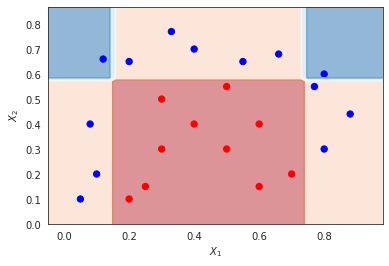

1.0

In [8]:
# Sklearn adaboost
boost = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes = 2), algorithm = 'SAMME',n_estimators=10, learning_rate=1.0)
boost.fit(X, y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

boost.score(X,y)

In [13]:
def Adaboost_scratch(X, y, M=10,learning_rate = 1):
    '''Initialization of utility variables'''
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]
    
    # Initialize the sample weights
    sample_weight = np.ones(N) /N
    sample_weight_list.append(sample_weight.copy())
    
    for m in range(M):
        
        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)
        
        #Estimator error
        estimator_error = np.mean(np.average(incorrect, weights = sample_weight, axis = 0))
        
        #Boost estimator weights
        estimator_weight = learning_rate * np.log((1. - estimator_error)/estimator_error)
        
        # Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight>0) | (estimator_weight<0)))
        
        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
    
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)
    
    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [14]:
estimator_list, estimator_weight_list, sample_weight_list  = Adaboost_scratch(X,y, M=10, learning_rate = 1)

Accuracy =  1.0


## REFERNCES: 

- [Gradient Boosting in Python from Scratch*](https://towardsdatascience.com/gradient-boosting-in-python-from-scratch-4a3d9077367#:~:text=Gradient%20boosting%20is%20an%20ensemble,what%20it's%20given%20as%20inputs.)
- [Gradient Boosting from scratch*](https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d)
- [Gradient Boosting (GBM) from Scratch - [Tutorial]](https://steemit.com/machine-learning/@cristi/gradient-boosting-gbm-from-scratch-tutorial)
- [How to explain gradient boosting](https://explained.ai/gradient-boosting/)
- [Demystifying Maths of Gradient Boosting](https://towardsdatascience.com/demystifying-maths-of-gradient-boosting-bd5715e82b7c#:~:text=The%20idea%20is%20simple%2D%20form,suitable%20number%20of%20base%20learners.)
- [A Gentle Introduction to Gradient Boosting](http://www.ccs.neu.edu/home/vip/teach/MLcourse/4_boosting/slides/gradient_boosting.pdf)
- [The Gradient Boosters I: The Good Old Gradient Boosting](https://deep-and-shallow.com/2020/02/02/the-gradient-boosters-i-the-math-heavy-primer-to-gradient-boosting-algorithm/)
- [Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)
- [Math behind GBM and XGBoost](https://medium.com/analytics-vidhya/math-behind-gbm-and-xgboost-d00e8536b7de)
- [Gradient Boosting Decision Tree Algorithm Explained*](https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4)
- []()